<h1>Visualising batch effects in PBMC's stained for T cell subsets</h1>

The first step in analysis is to make an assessment of the technical variation that could hinder analysis. For this we use the `CytoPy.flow.variance` module, housing visualisation tools for making assessment of batch effect.

In [2]:
# CytoPy imports
from CytoPy.data.setup import global_init
from CytoPy.data.project import Project
from CytoPy.flow import variance

In [3]:
# Other imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
sns.set(style="white", font_scale=1.3)

In [4]:
# Connect to local database
global_init("cytopy_db")

In [5]:
# Load the peritonitis database
peritonitis = Project.objects(project_id="Peritonitis").get()

In [6]:
# Fetch the experiment
exp = peritonitis.load_experiment("PBMC T cells")

The first step is to load some example data to work with. The `load_and_sample` method makes it possible to sample every sample in an experiment, transform the features of each independently, and generate a dataframe to work with.

In [13]:
features = ['FSC-A', 'SSC-A', 'CXCR3', 'CD161',
           'CCR7', 'Va7-2', 'CD8', 'Vd2', 'CD45RA', 
            'PanGD', 'CD4', 'CD27']
data = variance.load_and_sample(experiment=exp,
                                population="root",
                                sample_size=25000,
                                sampling_method="uniform",
                                transform="logicle",
                                features=features)[0]

  0%|          | 0/14 [00:00<?, ?it/s]

It's helpful to have a reference sample to serve as a comparison, so we find the sample that is 'average' amongst the samples of this experiment:

In [14]:
variance.calculate_ref_sample(data=data, features=features)

Calculate covariance matrix for each sample...
Search for sample with smallest average euclidean distance to all other samples...


'305-02'

We this reference sample we can start by plotting the individual channels. The reference sample is in blue and all other samples are overlaid for comparison:

  0%|          | 0/12 [00:00<?, ?it/s]

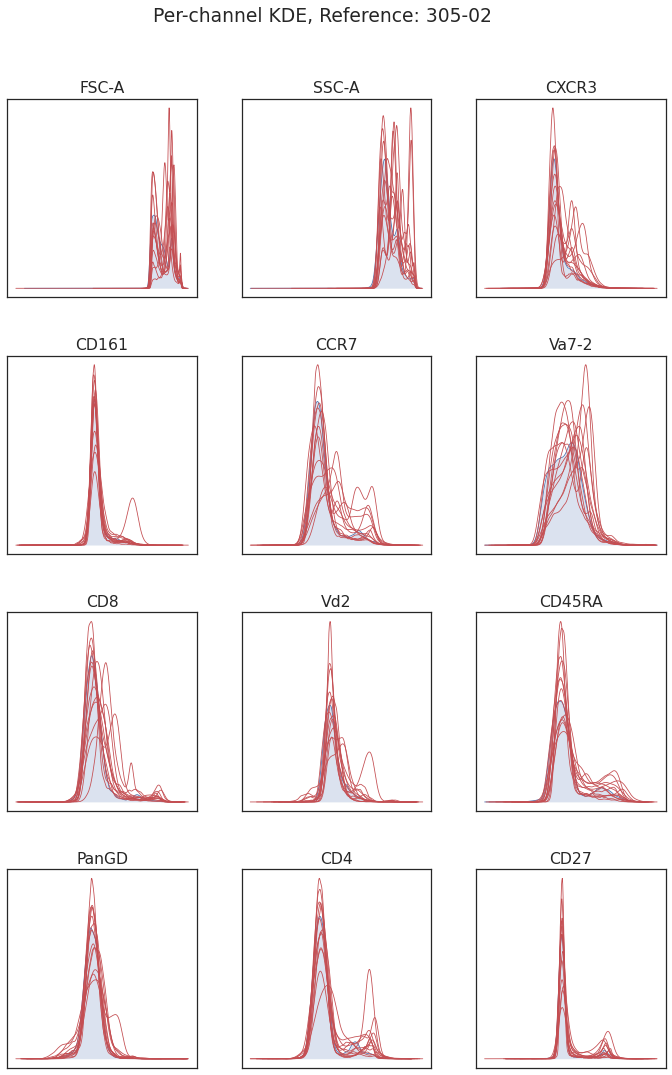

In [22]:
fig = variance.marker_variance(data=data,
                             reference="305-02",
                             markers=features,
                             figsize=(10, 15),
                             linewidth=0.8)
for ax in fig.axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("figures/marker_variance.png", dpi=300, facecolor="white")
plt.show()

The above is helpful to identify particular outliers and it's clear there are many, with batch effect likely an issue in this dataset, identified by significant drift in fluorescence in multiple channels. But to get a sense of the 'global' deviation we need to employ dimension reduction techniques. This can be achieved with the `dim_reduction_grid` function. The result is a grid of plots with the reference sample in the background and subsequent samples plotted over the top. The data is embedded into the same space so that the structure of single cell space can be compared.

We see that there are common structures shared across samples but significant 'drift' and a lack of alignment, suggesting technical variation.

  0%|          | 0/13 [00:00<?, ?it/s]

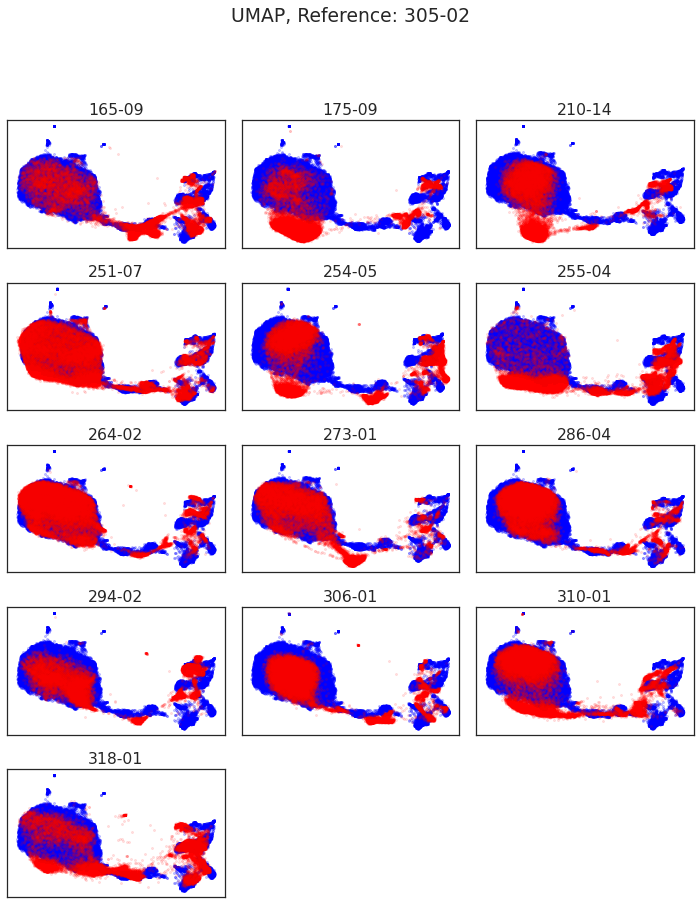

In [23]:
variance.dim_reduction_grid(data=data,
                            reference="305-02",
                            features=features,
                            figsize=(10, 12),
                            method="UMAP")
plt.savefig("figures/umap_variance.png", dpi=300, facecolor="white")
plt.show()

As a final means of comparing the landscape between samples we can employ the `SimilarityMatrix` class, which houses functionality to compute a pairwise statistical distance between samples and plot them as a clustered heatmap.

...performing dimensionality reduction


  0%|          | 0/14 [00:00<?, ?it/s]

...estimate PDFs of embeddings


  0%|          | 0/14 [00:00<?, ?it/s]

...calculating pairwise statistical distances


  0%|          | 0/14 [00:00<?, ?it/s]

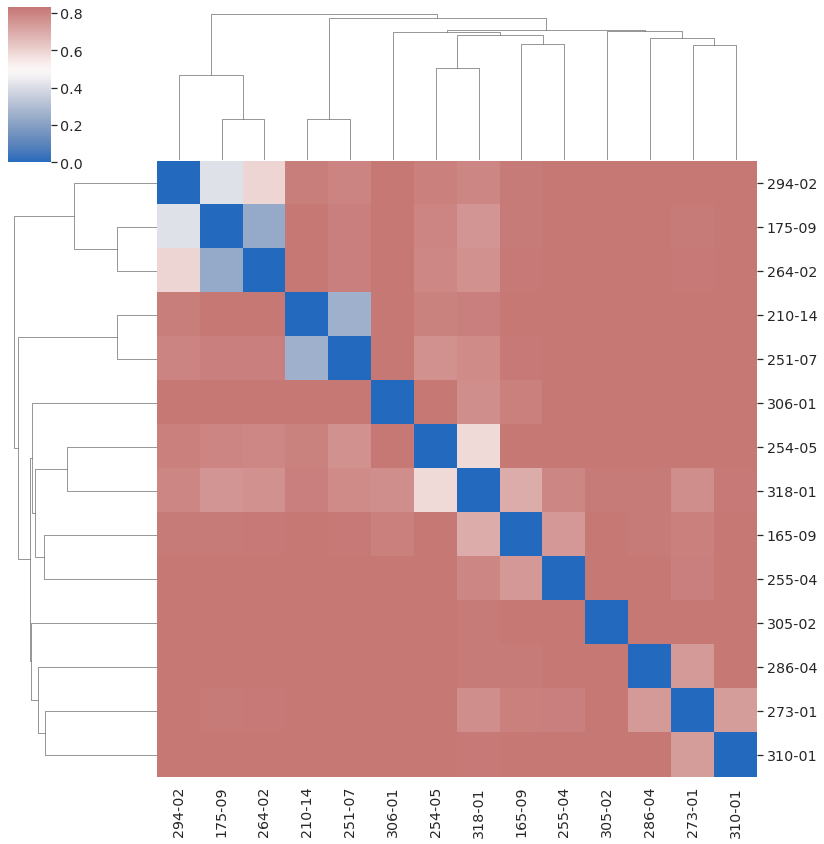

In [25]:
sim_matrix = variance.SimilarityMatrix(data=data,
                                       reference="305-02")
linkage, labels, g = sim_matrix(cluster_plot_kwargs={"xticklabels": True,
                                                     "yticklabels": True}, 
                                features=features)
plt.savefig("figures/sim_matrix.png", dpi=300, facecolor="white")
plt.show()